In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()
%matplotlib inline

In [2]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

In [3]:
os.chdir("/Users/juanvasquez/Downloads")

In [4]:
#This will be our error metric, so based on that we check how accurate the model is
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
df = pd.read_csv("conversion_rate.csv")
df.head()

,Date,Conversion_rate
0,2020-10-01,0.17544
1,2020-10-02,0.35640
2,2020-10-03,0.28836
3,2020-10-04,0.29432
4,2020-10-05,0.36222


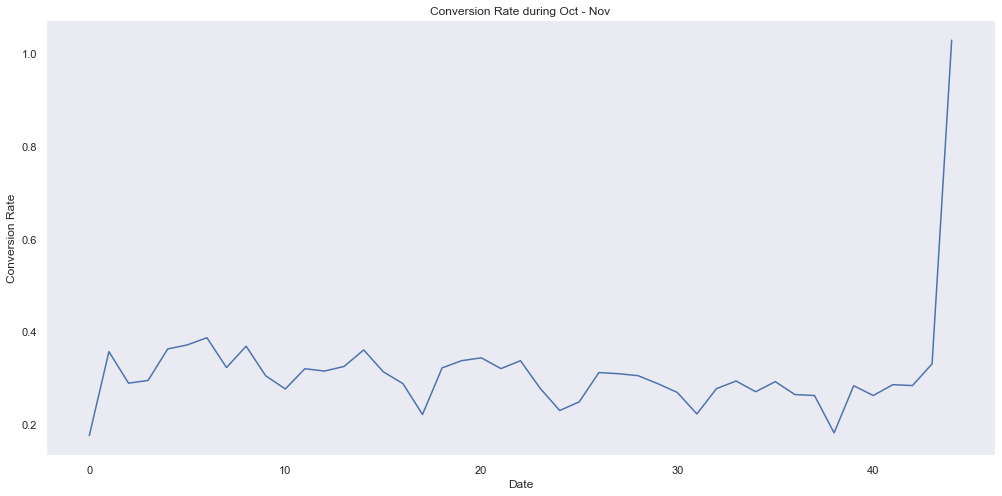

In [7]:
#Time Series for Conversion Rate:
plt.figure(figsize=(17, 8))
plt.plot(df.Conversion_rate)
plt.title('Conversion Rate during Oct - Nov')
plt.ylabel('Conversion Rate')
plt.xlabel('Date')
plt.grid(False)
plt.show()

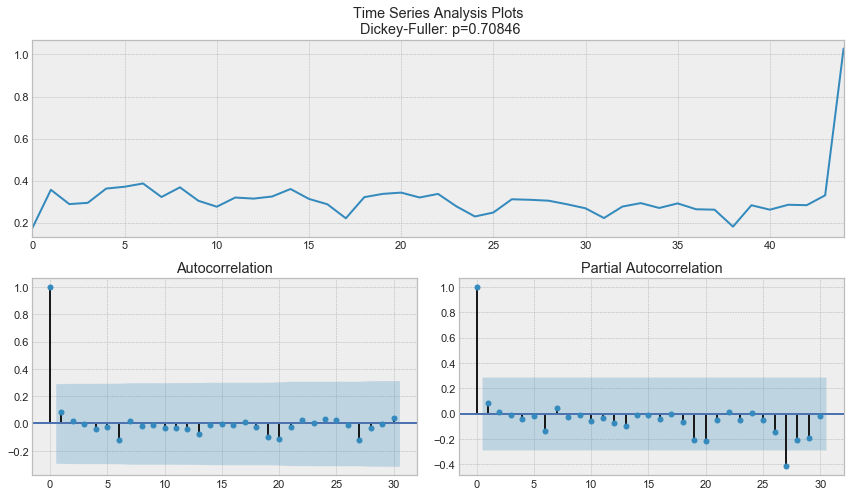

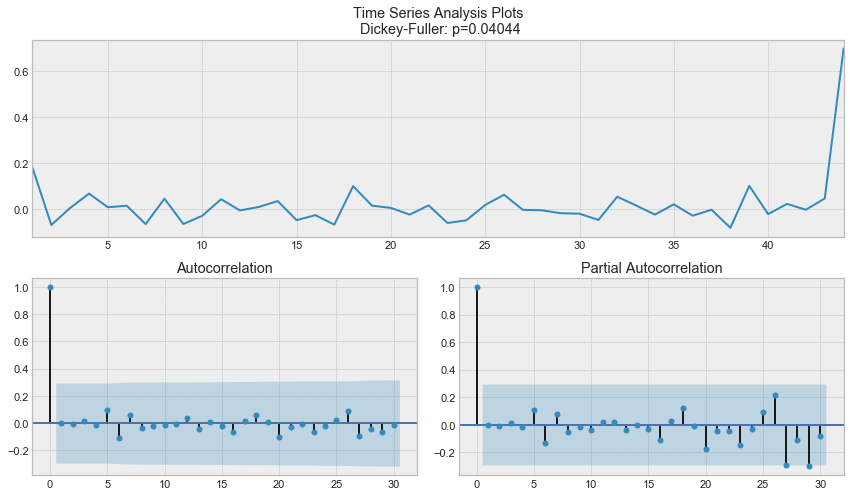

In [8]:
#Dickey Fuller Test and Autocorrelation Plot:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(df.Conversion_rate, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = df.Conversion_rate - df.Conversion_rate.shift(1)

tsplot(data_diff[1:], lags=30)

In [9]:

#In first image it can be observed  that the series are a non stationary proccess


In [10]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [11]:
# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(df.Conversion_rate, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(df.Conversion_rate, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

In [12]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                   Conversion_rate   No. Observations:                   45
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 5)   Log Likelihood                  27.546
Date:                           Mon, 07 Jun 2021   AIC                            -53.092
Time:                                   17:56:43   BIC                            -51.429
Sample:                                        0   HQIC                           -52.495
                                            - 45                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0143      0.001     12.222      0.000       0.012       0.017
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):               299.54
Prob(Q):                               nan   Prob(JB):                         0.00
Heteroskedasticity (H):               5.10   Skew:                             2.81
Prob(H) (two-sided):                  0.01   Kurtosis:                        15.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
model = sm.tsa.statespace.SARIMAX(df.Conversion_rate, order=(0,1,0),
                                               seasonal_order=(0,1,0,5))
results = model.fit()  
forecast = results.predict(n_periods=45)
df['forecast'] = forecast
#results.plot_diagnostics(figsize=(30,26))
df['MAPE'] = np.mean(np.abs((df['Conversion_rate'] - df['forecast']) /df['Conversion_rate'] )) * 100
df.head()

,Date,Conversion_rate,forecast,mape,MAPE
0,2020-10-01,0.17544,0.00000,23.236878,23.236878
1,2020-10-02,0.35640,0.17544,23.236878,23.236878
2,2020-10-03,0.28836,0.35640,23.236878,23.236878
3,2020-10-04,0.29432,0.28836,23.236878,23.236878
4,2020-10-05,0.36222,0.29432,23.236878,23.236878


No handles with labels found to put in legend.


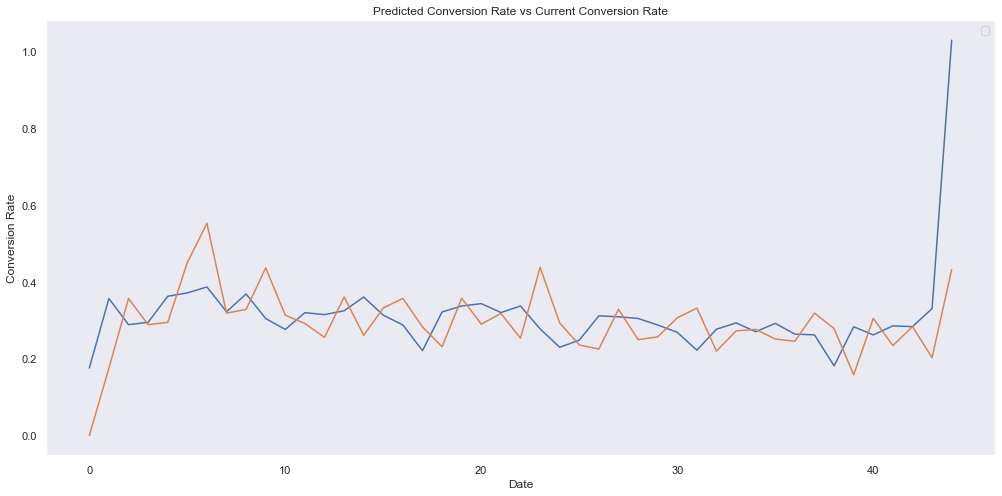

In [21]:
#Plot predicted vs actual price

plt.figure(figsize=(17, 8))
plt.plot(df.Conversion_rate)
plt.plot(df.forecast)
plt.title('Predicted Conversion Rate vs Current Conversion Rate')
plt.ylabel('Conversion Rate')
plt.xlabel('Date')
plt.legend(loc='best')
plt.grid(False)
plt.show()